In [5]:
import numpy as np
from scipy.constants import mu_0

# import pytest
# from scipy.io import netcdf_file
# from scipy.signal import convolve2d

# from desc.compute import data_index, rpz2xyz_vec
from desc.equilibrium import EquilibriaFamily, Equilibrium

# from desc.examples import get
from desc.geometry import (
    FourierPlanarCurve,
    FourierRZCurve,
    FourierRZToroidalSurface,
    FourierXYZCurve,
    ZernikeRZToroidalSection,
)
from desc.grid import LinearGrid, QuadratureGrid
from desc.profiles import PowerSeriesProfile

DESC version 0+untagged.5711.gad76a49.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 1.78 GB available memory


# Compute Test1

In [2]:
eq = Equilibrium()

B = eq.compute("B")["B"]

# Compute Test2

In [185]:
eq = Equilibrium(L=3, M=3, N=3)
grid = LinearGrid(rho=np.linspace(0.1,1,5), M=5, N=5)
rtz = grid.nodes
rho = grid.nodes[:, 0]
theta = grid.nodes[:, 1]
a0 = 4 / 5
a1 = 1 / 5
R = 10 + (a0 * rho + a1 * (3 * rho**3 - 2 * rho)) * np.cos(theta)
Z = -(a0 * rho + a1 * (3 * rho**3 - 2 * rho)) * np.sin(theta)
eq.set_initial_guess(grid, R, Z)
B = eq.compute("B", grid=grid)["B"]
B_norm = eq.compute("|B|", grid=grid)["|B|"]
J = eq.compute("J", grid=grid)["J"]
J_norm = eq.compute("|J|", grid=grid)["|J|"]
F_norm = eq.compute("|F|", grid=grid)["|F|"]
F = eq.compute("F", grid=grid)["F"]

In [172]:
def B_ana_cal(rho_in, a0, a1, Psi0):
    if len(rho_in.shape)>1:
        rho_in = rho[:,0]
    else:
        rho = rho_in
    return (
            Psi0
            / np.pi
            / (a0 + a1 * (3 * rho**2 - 2))
            / (a0 - 2 * a1 + 9 * a1 * rho**2)
        )

def B_vec_ana_cal(rtz, a0, a1, Psi0):
    rho = rtz[:,0]
    B = B_ana_cal(rho, a0, a1, Psi0)
    return np.stack((np.zeros_like(rho),B,np.zeros_like(rho)),axis=1)


def p_ana_cal(rho_in, a0, a1, Psi):
    if len(rho_in.shape)>1:
        rho_in = rho[:,0]
    else:
        rho = rho_in
    term1 = (a0 - 2 * a1 + 3 * a1 * rho**2) ** 2
    term2 = (a0 - 2 * a1 + 9 * a1 * rho**2) ** 2

    result = - 1 / (2 * term1 * term2) * Psi**2 / np.pi**2 / mu_0 

    return result


def j_ana_cal(rho_in, a0, a1, Psi):
    if len(rho_in.shape)>1:
        rho_in = rho[:,0]
    else:
        rho = rho_in
    numerator = 12 * a1 * rho * (2 * a0 - 4 * a1 + 9 * a1 * rho**2)
    denominator = (3 * a1 * rho**2 + a0 - 2 * a1) ** 2 * (
        9 * a1 * rho**2 + a0 - 2 * a1
    ) ** 3

    result = numerator / denominator * Psi / np.pi / mu_0

    return result

def j_vec_ana_cal(rtz, a0, a1, Psi):
    rho = rtz[:,0]
    theta = rtz[:,1]
    j = j_ana_cal(rho, a0, a1, Psi)
    return np.stack( (-j*np.sin(theta),np.zeros_like(rho), -j*np.cos(theta)),axis=1)


def gradp_ana_cal(rho, a0, a1, Psi):
    return j_ana_cal(rho, a0, a1, Psi) * B_ana_cal(rho, a0, a1, Psi)
def gradp_vec_ana_cal(rtz,a0,a1,Psi):
    rho = rtz[:,0]
    theta = rtz[:,1]
    F = gradp_ana_cal(rho, a0, a1, Psi)
    return np.stack( (F*np.cos(theta),np.zeros_like(rho), -F*np.sin(theta)),axis=1)

In [186]:
# Norm part of force balance 
np.testing.assert_allclose(J_norm*B_norm, F_norm, atol=1e-15,rtol=1e-15)

In [187]:
B_ana = B_ana_cal(rho, a0, a1, eq.Psi)
B_vec_ana = B_vec_ana_cal(rtz, a0,a1, eq.Psi)
J_ana = j_ana_cal(rho, a0, a1, eq.Psi)
J_vec_ana = j_vec_ana_cal(rtz, a0, a1, eq.Psi)
p_ana = p_ana_cal(rho, a0, a1, eq.Psi)
gradp_ana = gradp_ana_cal(rho, a0, a1, eq.Psi)
gradp_vec_ana = gradp_vec_ana_cal(rtz, a0, a1, eq.Psi)

In [188]:
np.testing.assert_allclose(B, B_vec_ana, atol=1e-10, rtol=1e-10)
np.testing.assert_allclose(J, J_vec_ana, atol=1e-5, rtol=1e-5)
np.testing.assert_allclose(F, gradp_vec_ana, atol=1e-6,rtol=1e-10)

## Test azimuthal independence

In [116]:
grid = LinearGrid(
    rho=[0.5], theta=np.linspace(0, 2 * np.pi, 10), zeta=np.linspace(0, 2 * np.pi, 10)
)

In [67]:
from desc.compute.utils import dot

In [119]:
name = "J"
np.linalg.norm(eq.compute(name, grid=grid)[name], axis=1)

array([2045263.96160325, 2045263.96160325, 2045263.96160326,
       2045263.96160326, 2045263.96160327, 2045263.96160327,
       2045263.96160327, 2045263.96160326, 2045263.96160325,
       2045263.96160325, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160327, 2045263.96160327, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160327, 2045263.96160327,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160327,
       2045263.96160327, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160327, 2045263.96160327, 2045263.96160326,
       2045263.96160326,

In [120]:
name = "F"
np.linalg.norm(eq.compute(name, grid=grid)[name], axis=1)

array([1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.7033877 ,
       1392572.7033877 , 1392572.70338769, 1392572.70338768,
       1392572.70338768, 1392572.70338768, 1392572.70338769,
       1392572.70338769, 1392572.70338768, 1392572.70338768,
       1392572.70338769, 1392572.70338769, 1392572.70338769,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.70338769,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.70338769,
       1392572.70338769, 1392572.70338769, 1392572.70338768,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338769, 1392572.70338768, 1392572.70338768,
       1392572.70338769, 1392572.70338769, 1392572.70338769,
       1392572.70338768,

# Compute Test 3

# Solve Test

In [3]:
Psi = 1
a = 1
R = 10
A = ((2 * Psi) / (np.pi * a**2 * (np.sqrt(2) + 1))) ** 2
p_coeff = A / 2 / mu_0

p = PowerSeriesProfile(params=[p_coeff, -p_coeff], modes=[0, 2])

iota = PowerSeriesProfile(params=[0, 0])

surf = FourierRZToroidalSurface(
    R_lmn=[R, a],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[0, -a],
    modes_Z=[[0, 0], [-1, 0]],
)

In [26]:
eq = Equilibrium(
    surface=surf,
    pressure=p,
    iota=iota,
    Psi=Psi,
    NFP=1,
    L=15,
    M=5,
    N=0,
    L_grid=24,
    M_grid=6,
    N_grid=0,
)

In [52]:
from desc.plotting import plot_2d, plot_3d, plot_surfaces, plot_basis, plot_section

(<Figure size 359.711x359.711 with 2 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J}|$ ($A \\cdot m^{-2}$), $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

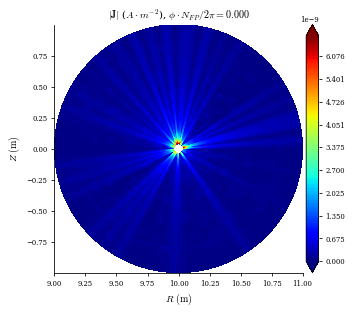

In [55]:
plot_section(eq,"|J|")

In [43]:
grid = LinearGrid(
    rho=[0.5],
    theta=np.linspace(0, 2 * np.pi, 20),
    zeta=np.linspace(0, 2 * np.pi, 20),
)

(<Figure size 287.769x359.711 with 1 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

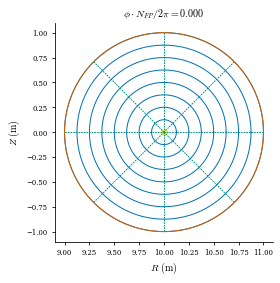

In [51]:
plot_surfaces(eq)

In [5]:
from desc.optimize import Optimizer
from desc.objectives import (
    get_fixed_boundary_constraints,
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixIota,
    FixPsi,
    ForceBalance,
)

optimizer = Optimizer("lsq-exact")
constraints = (
    FixBoundaryR(eq=eq),  # enforce fixed  LCFS for R
    FixBoundaryZ(eq=eq),  # enforce fixed  LCFS for Z
    FixPressure(eq=eq),  # enforce that the pressure profile stay fixed
    FixIota(eq=eq),  # enforce that the rotational transform profile stay fixed
    FixPsi(eq=eq),  # enforce that the enclosed toroidal stay fixed
)
objectives = ForceBalance(eq=eq)
obj = ObjectiveFunction(objectives=objectives)

In [7]:
eq.solve(
    verbose=3,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
    maxiter=10,
    constraints=constraints,
    optimizer=optimizer,
    objective=obj,
)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.40 sec
Timer: Objective build = 5.25 sec
Timer: Linear constraint projection build = 8.08 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 570 ms
Timer: Jacobian compilation time = 1.40 sec
Timer: Total compilation time = 1.97 sec
Number of parameters: 99
Number of objectives: 110
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.365e-03                                    2.363e-01   
       1              3          5.130e-04      8.522e-04      3.481e-02      1.655e-01   
       2              4          9.827e-05      4.147e-04      5.451e-02      7.462e-02   
       3              5          4.259e-06      9.401e-05      1.296e-01      5.823e-02   
       4              6          8.116e-07      3.447e-06      2.035e-01      2.462e-

(Equilibrium at 0x17a6a2050 (L=15, M=5, N=0, NFP=1, sym=True, spectral_indexing=ansi),
     message: Maximum number of iterations has been exceeded.
     success: False
         fun: [ 1.638e-11 -1.272e-09 ...  4.197e-11 -9.843e-10]
           x: [-3.455e+00  1.317e+00 ... -1.637e-05  1.013e+01]
         nit: 10
        cost: 1.472224773185259e-13
           v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
  optimality: 6.362344037633483e-06
        nfev: 15
        njev: 11
        allx: [Array([ 1.000e+01,  1.000e+00, ...,  0.000e+00, -1.000e+00],      dtype=float64), Array([ 9.999e+00,  1.010e+00, ...,  0.000e+00, -1.000e+00],      dtype=float64), Array([ 9.998e+00,  1.024e+00, ...,  0.000e+00, -1.000e+00],      dtype=float64), Array([ 1.001e+01,  1.034e+00, ...,  0.000e+00, -1.000e+00],      dtype=float64), Array([ 1.002e+01,  1.025e+00, ...,  0.000e+00, -1.000e+00],      dtype=float64), Array([ 1.001e+01,  1.025e+00, ...,  0.000e+00, -1.000e+00],      dtype=float64), Array([ 1

In [ ]:
from desc.continuation import solve_continuation_automatic

solve_continuation_automatic(eq)

In [206]:
grid = LinearGrid(rho=np.linspace(0, 1, 11), theta=[np.pi * 0.0], zeta=[0])

data = eq.compute(["R", "Z"], grid=grid)
rho = np.linalg.norm(np.stack((data["R"] - R, data["Z"]), axis=1), axis=1)

In [207]:
rho

array([0.06327124, 0.17304309, 0.27785117, 0.37718508, 0.47118757,
       0.56068988, 0.64714855, 0.73247392, 0.81872573, 0.90763888,
       1.        ])

In [183]:
def r_test(rho, a):
    return np.sqrt(np.sqrt(2) + 1) * a * np.sqrt(np.sqrt(1 + rho**2) - 1)

In [184]:
r_test(grid.nodes[:, 0], a)

array([0.        , 0.10973167, 0.21865692, 0.32603588, 0.43124705,
       0.53381575, 0.63341856, 0.72986961, 0.82309678, 0.91311478,
       1.        ])